In [1]:
import sys 

import sklearn
import numpy as np 
import os
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.utils import io

import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict,GridSearchCV
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,r2_score,mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor



## Cleaning the data

In [2]:
df : pd.DataFrame = pd.read_csv('my_data.csv')

In [3]:
df.head()

,Unnamed: 0,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,price,num of bids,num of comments,num of images
0,0,2018,BMW,328d,"13,800",LA,2.0L,I4,4WD/AWD,Automatic,8-Speed,Wagon,Black Sapphire Metallic,5,3,"$43,500",37,64,129
1,1,2003,Audi,S8,"178,300",MD,4.2L,V8,4WD/AWD,Automatic,5-Speed,Sedan,Ming Blue Pearl,6,10,"$8,800",38,57,141
2,2,1985,Chevrolet,Corvette,"1,700",GA,5.7L,V8,Rear-wheel drive,Automatic,4-Speed,Coupe,Red,6,3,"$15,450",57,45,132
3,3,2003,Toyota,Land Cruiser,"182,900",MD,4.7L,V8,4WD/AWD,Automatic,5-Speed,SUV/Crossover,Galactic Gray Mica,5,11,"$24,000",36,28,120
4,4,2014,BMW,335i,"87,600",CA,3.0L,I6,Rear-wheel drive,Automatic,8-Speed,Sedan,Black Sapphire Metallic,5,7,"$17,000",11,22,126


in one page there was no year of prduction, insted it was "Consumer" somthing.. so I just deleted this row,  + the Unamed:0 colum the was the resualt of combing of all the dataframes from the scrapper.

In [4]:
df = df.drop("Unnamed: 0",axis=1)
df = df.drop(df.loc[df['year'] == '"Consumer'].index)

### fixing the numerical columns

Some columns are in numbers, but becuase there was a charecter in them ('$',',','L') so I needed to prase the change them to numerical data(int/float)

In the price column all we need to do is to remove the '$' symbol infront and remove the ','

In [5]:
df["price"] = df["price"].apply(lambda x: x[1:])
df["price"] = df["price"].apply(lambda x: x.replace(",",""))

In the mileage column, we remove the ',' smbol as well as the '~' symbol that were on one car.
moreover their were some comments on the mileage column, that said xxxx miles on the odometer, I also got rid of them.

In [6]:
def get_miles_from_str(x):
    if isinstance(x,int):
        return x
    x = x.replace(",","")
    x = x.split(" ")[0]
    x = x.replace("~","")
    if x[0].isdigit():
        return x
    return 0

df["mileage"] = df["mileage"].apply(lambda x: get_miles_from_str(x))

In the engine colum their were more problems. Some were electric, some in Liters, some in cc and some were completlly missing.
I fixed the missing manually by checking simmilar cars. 
all of the Electric cars were given 0 engine size, and all the other car's engine size were represented in cc

In [7]:
df["engine size"] = df["engine size"].replace(['Single','Dual','Triple','AC','EV'],0)
def convert(x : str):
    if isinstance(x,int):
        return x
    elif "cc" in x:
        x = x.replace("cc","")
        return int(x)
    elif "Liter" in x:
        x = x.replace("-Liter","")
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"
        return int(x)
    elif "L" in x:
        x = x.replace("L","")
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"
        return int(x)
    elif "." in x:
        x = x.replace(".","")
        x = x.replace("-liter","")
        for i in range(0,4 -len(x)):
            x = x + "0"
        return int(x)
    else:
        return x
    

df["engine size"] = df["engine size"].apply(convert)

In [8]:
to_fix_df = []
def convert(x : int):
    try:
        y = int(x)
        if isinstance(y,int):
            return x
    except ValueError:    
        to_fix_df.append(df.loc[df['engine size'] == x])


df["engine size"].apply(convert);
to_fix_df[0]
tf = pd.DataFrame()
for f in to_fix_df:
    tf = pd.concat([tf,f])
tf
df = df.drop(tf.index)

In [9]:
df['engine size'].unique()

array([2000, 4200, 5700, 4700, 3000, 4400, 6200, 6800, 4000, 4600, 2500,
       1000, 3400, 2700, 2800, 6300, 5400, 2900, 2400, 4500, 6750, 5000,
       1800, 1600, 4300, 2200, 5300, 3800, 3200, 2300, 3600, 5500, 6000,
       3500, 4800, 8000, 4900, 1300, 3300, 3700, 5900, 6700, 1700, 5200,
       987, 1400, 6400, 6500, 660, 5800, 8300, 6600, 602, 659, 657, 1500,
       1100, 7000, 2250, 5600, 2600, 700, 7400, 7300, 1900, 7500, 0, 8100,
       1200, 548, 658, 1080, 547, 8400, 3900, 656, 6100, 2100, 3100, 4100,
       7200, 600, 2850, 6900, 1750], dtype=object)

again, not all post were equal. So I had to fix it manually.

I also combined all the same engines, that had different names like "I4", "Inline-4","i-4" etc...

In [10]:
df.loc[df["engine type"] == "Canada","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Supercharged","engine type"] = "V6"
df.loc[df["engine type"] == "Diesel","engine type"] = "I4"
df.loc[df["engine type"] == "3.0L","engine type"] = "I6"
df.loc[df["engine type"] == "turbodiesel","engine type"] = "I6"
df.loc[df["engine type"] == "I-6","engine type"] = "I6"
df.loc[df["engine type"] == "Turbodiesel","engine type"] = "V6"
df.loc[df["engine type"] == "Turbo","engine type"] = "I4"
df.loc[df["engine type"] == "4","engine type"] = "Flat-4"
df.loc[df["engine type"] == "6","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Inline-4","engine type"] = "I4"
df.loc[df["engine type"] == "i4","engine type"] = "I4"
df.loc[df["engine type"] == "I-4","engine type"] = "I4"
df.loc[df["engine type"] == "I-3","engine type"] = "I3"
df.loc[df["engine type"] == "Hybrid","engine type"] = "V6"
df.loc[df["engine type"] == "H6","engine type"] = "Flat-6"
df.loc[df["engine type"] == "H4","engine type"] = "Flat-4"
df.loc[df["engine size"] == 0,"engine type"] = "electric"

I changed the number of gears, so that I have this column in integers. and again' needed to fix some values manually

In [11]:
df.loc[df["number of gears"] == "3.6L V6","number of gears"] = "6-speed"
def simplefy_gears(x:str):
    if not isinstance(x,str):
        return 0
    if x == "CVT":
        return -1
    x = x.split("-")[0]
    return x

df["number of gears"] = df["number of gears"].apply(simplefy_gears)

There were to many collor. So I grouped all of them together

In [13]:
def simplefy_color(x : str):
    if "white" in x.lower():
        x = "white"
    elif "black" in x.lower():
        x = "black"
    elif "red" in x.lower():
        x = "red"
    elif "blue" in x.lower():
        x = "blue"
    elif "yellow" in x.lower():
        x = "yellow"
    elif "grey" in x.lower():
        x = "grey"
    elif "green" in x.lower():
        x = "green"
    elif "silver" in x.lower():
        x = "silver"
    elif "orange" in x.lower():
        x = "orange"
    elif "metallic" in x.lower():
        x = "metallic"
    elif "pearl" in x.lower():
        x = "pearl"
    elif "gold" in x.lower():
        x = "gold"
    elif "beige" in x.lower():
        x = "beige"
    else:
        x = "special"

    return x

df["color"] = df["color"].apply(simplefy_color)

In [14]:
df["price"] = df['price'].astype(str).astype(int)
df["mileage"] = df['mileage'].astype(str).astype(int)
df["year"] = df['year'].astype(str).astype(int)
df["engine size"] = df['engine size'].astype(str).astype(int)
df["number of gears"] = df['number of gears'].astype(str).astype(int)

In [15]:
df["mileage"].unique

<bound method Series.unique of 0        13800
1       178300
2         1700
3       182900
4        87600
         ...  
5752    117273
5753     14816
5754     47316
5755     55169
5756     87200
Name: mileage, Length: 5749, dtype: int64>

I combined this cloumn to describe how detailed was the post. It made sense that a more detailed post, were bidded higher

In [16]:
df["is descreptive"] = df["numberg of higlights"] + df["number of flaws"] > 15
df["is descreptive"] = df["is descreptive"].map({
    True: 1,
    False: 0
})

df = df.drop(["numberg of higlights","number of flaws"],axis=1)

In [17]:
df.describe(include='all')

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,price,num of bids,num of comments,num of images,is descreptive
count,5749.000000,5749,5749,5749.000000,5749,5749.000000,5749,5749,5749,5749.000000,5749,5749,5749.000000,5749.000000,5749.000000,5749.000000,5749.000000
unique,NaN,93,799,NaN,64,NaN,20,3,2,NaN,8,14,NaN,NaN,NaN,NaN,NaN
top,NaN,BMW,911,NaN,CA,NaN,V8,Rear-wheel drive,Automatic,NaN,Sedan,black,NaN,NaN,NaN,NaN,NaN
freq,NaN,1072,157,NaN,1108,NaN,2158,3124,3319,NaN,1430,1232,NaN,NaN,NaN,NaN,NaN
mean,2004.078448,NaN,NaN,79099.753870,NaN,3711.639242,NaN,NaN,NaN,5.537659,NaN,NaN,23747.895808,28.182814,69.098104,114.795269,0.129936
std,9.478959,NaN,NaN,55025.666621,NaN,1469.539316,NaN,NaN,NaN,1.308070,NaN,NaN,25335.072480,13.287470,52.833776,45.395042,0.336262
min,1981.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,-1.000000,NaN,NaN,1800.000000,1.000000,2.000000,37.000000,0.000000
25%,1997.000000,NaN,NaN,38100.000000,NaN,2500.000000,NaN,NaN,NaN,5.000000,NaN,NaN,9350.000000,18.000000,36.000000,82.000000,0.000000
50%,2005.000000,NaN,NaN,70100.000000,NaN,3500.000000,NaN,NaN,NaN,6.000000,NaN,NaN,15900.000000,27.000000,56.000000,105.000000,0.000000
75%,2012.000000,NaN,NaN,110000.000000,NaN,4800.000000,NaN,NaN,NaN,6.000000,NaN,NaN,27890.000000,36.000000,86.000000,137.000000,0.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749 entries, 0 to 5756
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   year               5749 non-null   int64 
 1   make               5749 non-null   object
 2   model              5749 non-null   object
 3   mileage            5749 non-null   int64 
 4   state of origin    5749 non-null   object
 5   engine size        5749 non-null   int64 
 6   engine type        5749 non-null   object
 7   drivetrain         5749 non-null   object
 8   transmmision type  5749 non-null   object
 9   number of gears    5749 non-null   int64 
 10  body_style         5749 non-null   object
 11  color              5749 non-null   object
 12  price              5749 non-null   int64 
 13  num of bids        5749 non-null   int64 
 14  num of comments    5749 non-null   int64 
 15  num of images      5749 non-null   int64 
 16  is descreptive     5749 non-null   int64 


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'engine size'}>],
       [<AxesSubplot:title={'center':'number of gears'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'num of bids'}>],
       [<AxesSubplot:title={'center':'num of comments'}>,
        <AxesSubplot:title={'center':'num of images'}>,
        <AxesSubplot:title={'center':'is descreptive'}>]], dtype=object)

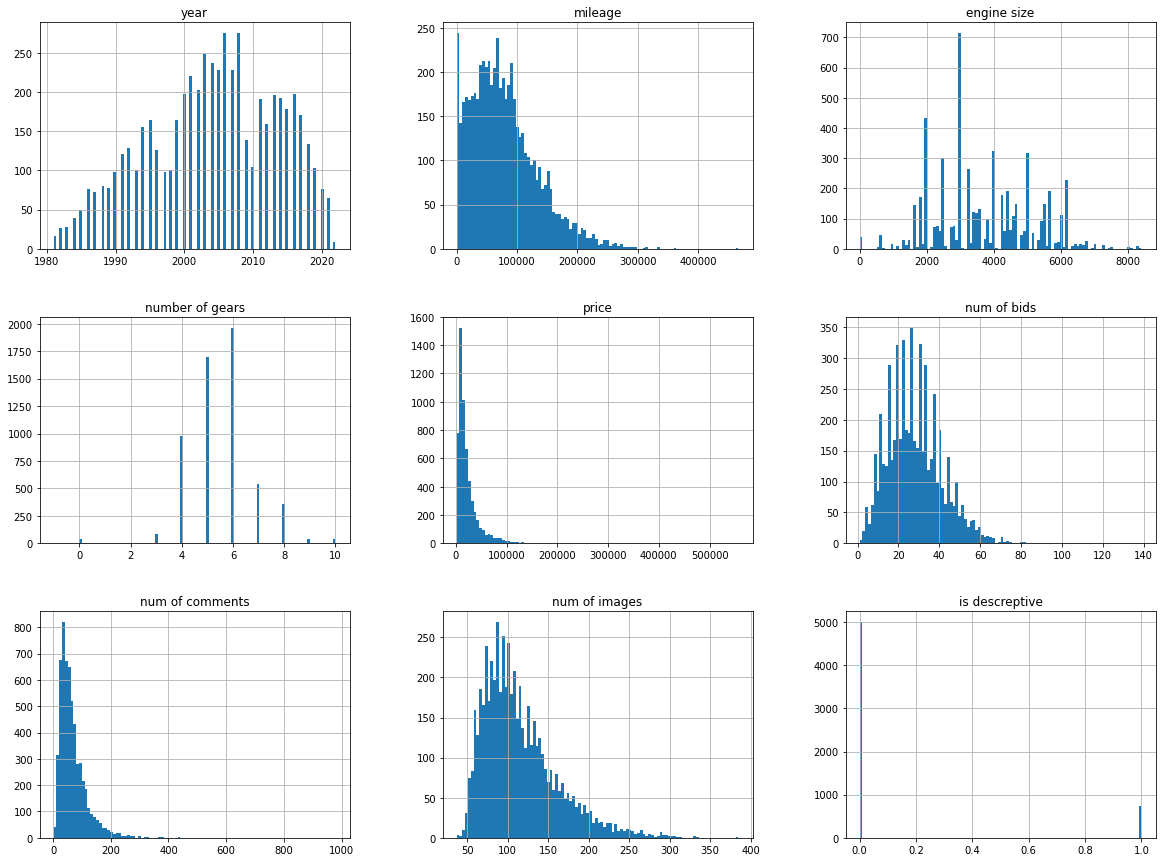

In [19]:
fig_size=(20,15)
df.hist(bins=100, figsize=(20,15))

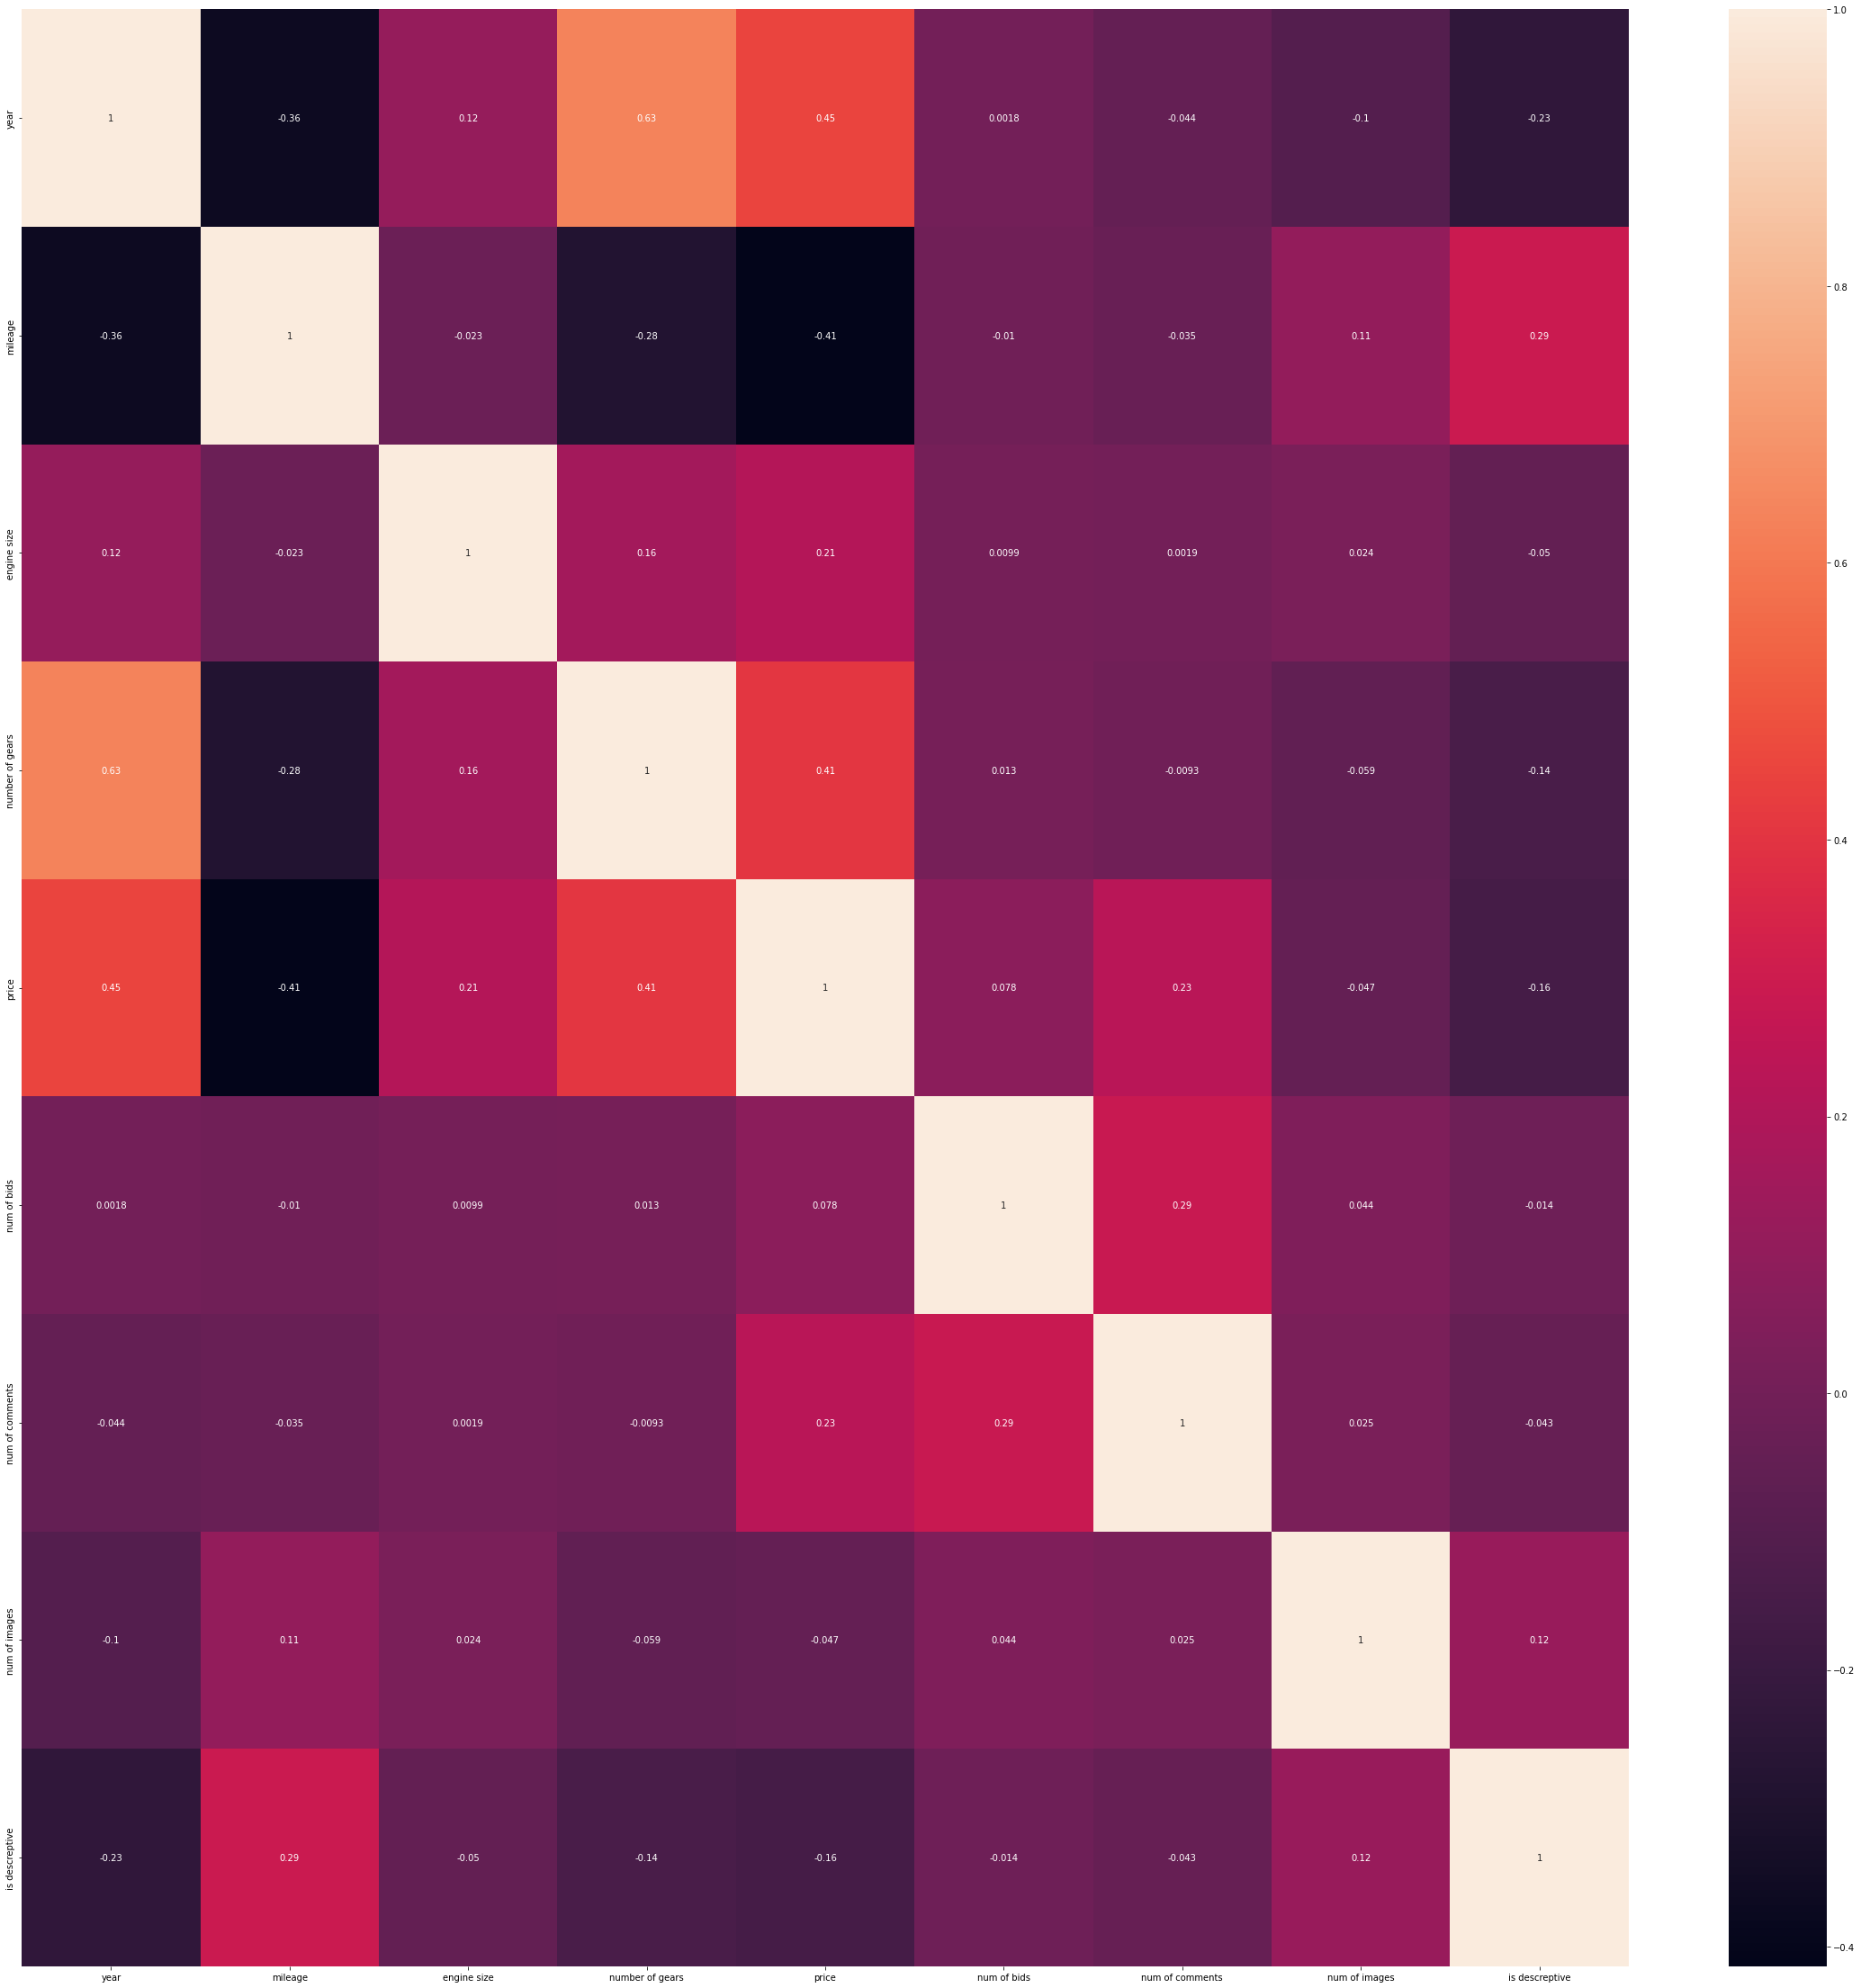

In [20]:
corr_mat= df.corr()
f, ax = plt.subplots(figsize=(40,40))
sns.heatmap(corr_mat,annot=True);

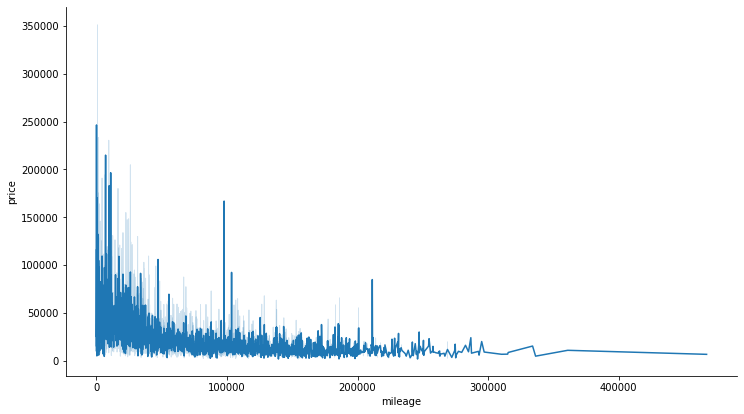

In [21]:
mileage_price_rel = sns.relplot(x="mileage", y="price" ,data=df,kind='line')
mileage_price_rel.fig.set_figwidth(12)
mileage_price_rel.fig.set_figheight(6)

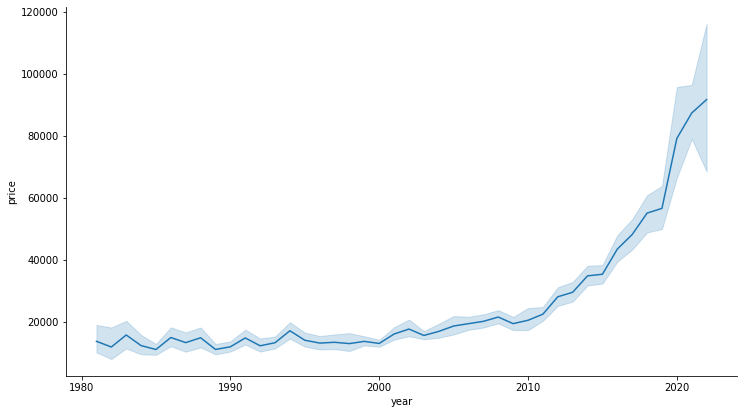

In [22]:
year_price_rel = sns.relplot(x="year", y="price" ,data=df,kind='line')
year_price_rel.fig.set_figwidth(12)
year_price_rel.fig.set_figheight(6)

We can see that the data is scatterd around, and althoguht their is slight increse in engine size comparred to the price, it still looks quite random.

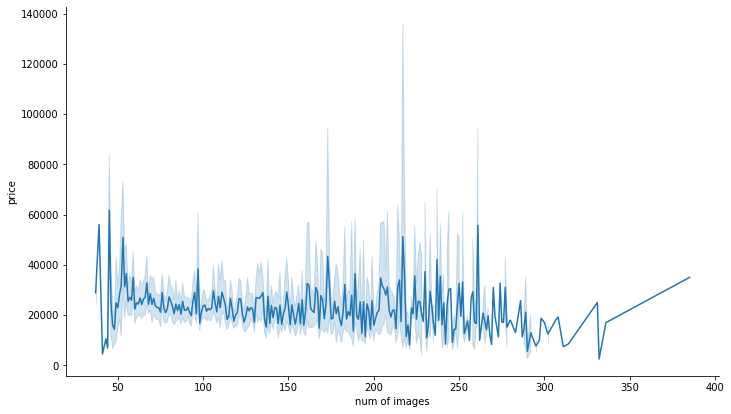

In [23]:
images_price_rel = sns.relplot(x="num of images", y="price" ,data=df,kind='line')
images_price_rel.fig.set_figwidth(12)
images_price_rel.fig.set_figheight(6)

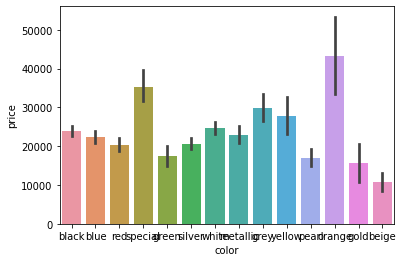

In [24]:
color_price_rel = sns.barplot(x="color", y="price" ,data=df)

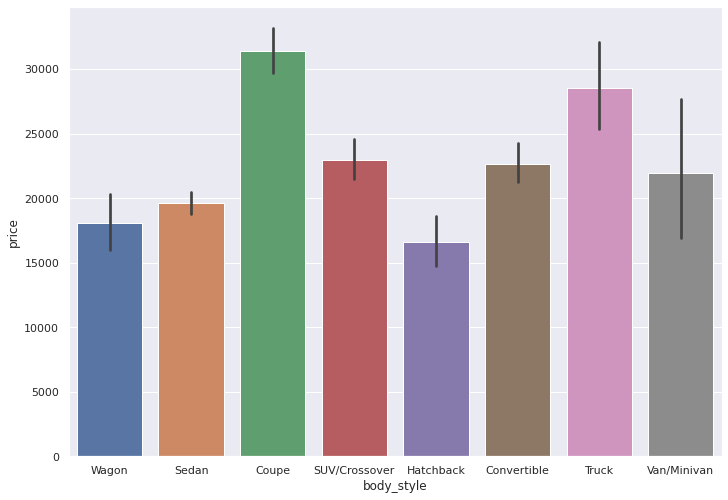

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
body_price_rel = sns.barplot(x="body_style", y="price" ,data=df)

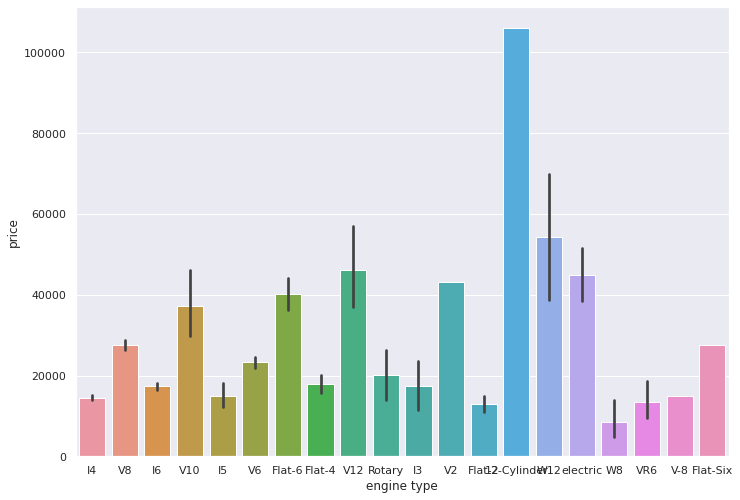

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
body_price_rel = sns.barplot(x="engine type", y="price" ,data=df)

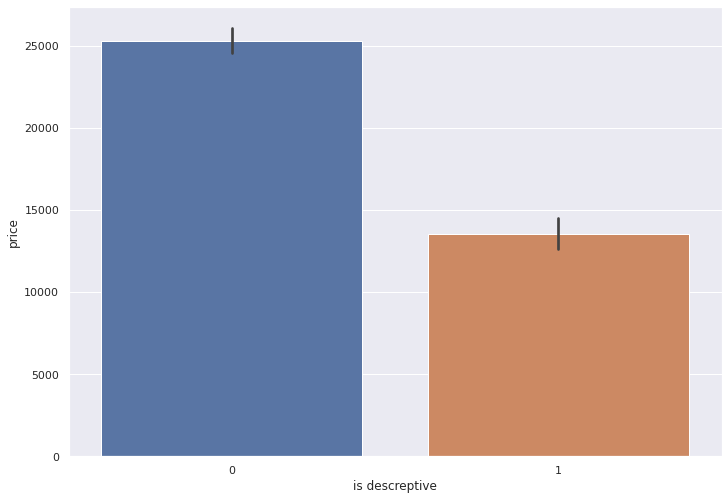

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
body_price_rel = sns.barplot(x="is descreptive", y="price" ,data=df)

In [28]:
df = df.drop(df.loc[(df["price"] > 100000)].index)
df = df.drop(df.loc[(df["mileage"] > 300000)].index)
df = df.drop(df.loc[(df["num of images"] > 250)].index)
df = df.drop(df.loc[(df["num of comments"] > 200)].index)

In [29]:
df = df.drop(df[df.groupby('make')['make'].transform('size') <= 5].index)

In [30]:
cars_df_with_dummies = pd.get_dummies(df)

In [31]:
cars_df_with_dummies

,year,mileage,engine size,number of gears,price,num of bids,num of comments,num of images,is descreptive,make_AM General,...,color_green,color_grey,color_metallic,color_orange,color_pearl,color_red,color_silver,color_special,color_white,color_yellow
0,2018,13800,2000,8,43500,37,64,129,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2003,178300,4200,5,8800,38,57,141,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1985,1700,5700,4,15450,57,45,132,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2003,182900,4700,5,24000,36,28,120,1,0,...,0,0,0,0,0,0,0,1,0,0
4,2014,87600,3000,8,17000,11,22,126,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5751,2003,89786,2400,5,8000,15,86,121,0,0,...,0,0,0,0,0,0,0,0,0,1
5752,1984,117273,4200,4,15000,38,93,65,0,0,...,0,0,0,0,0,0,0,0,0,0
5753,2001,14816,2000,6,21250,31,101,128,0,0,...,0,0,0,0,0,1,0,0,0,0
5754,1994,47316,3500,5,32000,44,163,161,0,0,...,0,0,0,0,0,1,0,0,0,0


In [32]:
df = df.drop(['num of bids','num of comments','num of images'],axis=1)

In [33]:
std_scaler = StandardScaler()

price_label = cars_df_with_dummies['price']
cars_without_price = cars_df_with_dummies.drop(['price'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(cars_without_price,price_label,test_size=0.2,random_state=42)

num_features = ['year','mileage','engine size','number of gears']

X_train[num_features] = std_scaler.fit_transform(X_train[num_features])
X_test[num_features] = std_scaler.transform(X_test[num_features])

In [44]:
linear_reg = LinearRegression(normalize = False,positive = True)
linear_reg.fit(X_train, y_train)
initial_prediction = linear_reg.predict(X_test)


print(r2_score(y_test,initial_prediction))
print (mean_absolute_error(y_test,initial_prediction))

-2.938171708569708e+24
4158372628965358.0


In [52]:
knn_reg = KNeighborsRegressor(n_neighbors=50,weights='distance',p=10)
knn_reg.fit(X_train, y_train)
initial_prediction = knn_reg.predict(X_test)

print(r2_score(y_test,initial_prediction))
print (mean_absolute_error(y_test,initial_prediction))

-0.009577973877422874
12522.591203130216


In [54]:
rf_reg = RandomForestRegressor(criterion="absolute_error")
rf_reg.fit(X_train, y_train)
initial_prediction = rf_reg.predict(X_test)


print(r2_score(y_test,initial_prediction))
print (mean_absolute_error(y_test,initial_prediction))

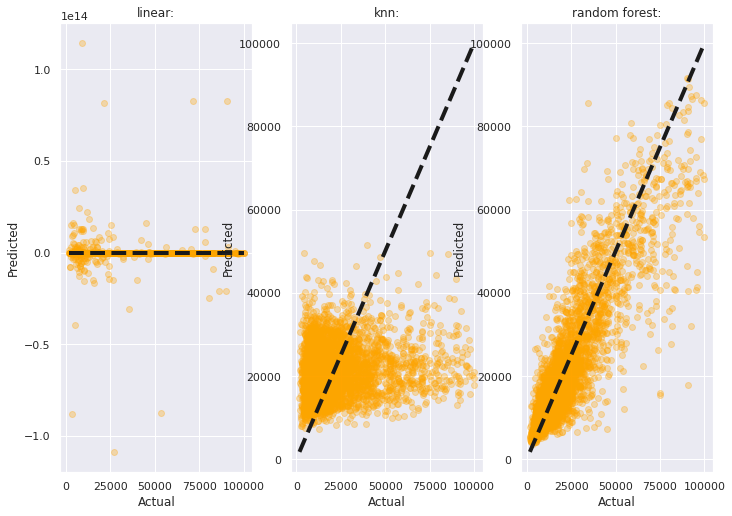

In [38]:
fig, axes = plt.subplots(1,3)
((ax1, ax2, ax3)) = axes

y_predicted = cross_val_predict(linear_reg, X_train, y_train, cv=10)
ax1.scatter(y_train, y_predicted, alpha=0.3, color='orange')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('linear:')

y_predicted = cross_val_predict(knn_reg, X_train, y_train, cv=10)
ax2.scatter(y_train, y_predicted, alpha=0.3, color='orange')
ax2.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title('knn:')

y_predicted = cross_val_predict(rf_reg, X_train, y_train, cv=10)
ax3.scatter(y_train, y_predicted, alpha=0.3, color='orange')
ax3.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax3.set_xlabel('Actual')
ax3.set_ylabel('Predicted')
ax3.set_title('random forest:')

plt.show()